\begin{equation}\label{eq:superposition}
    |\Phi_\alpha (R)\rangle = \sum_i c_i^{\alpha} |\phi_i\rangle,
\end{equation}
where $c_i^\alpha$ come from the eigenvectors of ${\bf H}_{Tot}$ in the local basis.  The total photonic contribution to a given state $\alpha$ will be given by
\begin{equation}
P_c^{\alpha} = \sum_p |c_p^{\alpha}|^2
\end{equation}
where the index $p$ runs only over local basis states where the cavity is occupied by a photon.  Note that the array attribute `self.gamma_diss` has non-zero values only in 
positions that correspond to the indices of local basis states where the cavity is occupied
by a photon, so we can use this array attribute to determine which coefficients we include in the sum.

No handles with labels found to put in legend.


gamma [0.00000000e+00 3.67498438e-06 3.67498438e-06 7.34996876e-06
 0.00000000e+00 3.67498438e-06 3.67498438e-06 7.34996876e-06]
[[ 9.99964575e-01  2.69091390e-19 -9.55784155e-19  7.21054650e-18
  -6.13762679e-03  2.78301841e-03  5.04321901e-03 -3.00938915e-20]
 [-7.63549810e-18  6.66662397e-02 -1.16439669e-01  9.90939087e-01
   6.75911586e-16 -4.87386319e-16 -6.12377965e-16  6.09438889e-03]
 [ 1.02663179e-19  8.05721739e-01  5.92067388e-01  1.53292079e-02
  -2.99992372e-16  1.42310972e-16 -3.87231846e-16  5.80545625e-03]
 [ 6.93820378e-05 -1.53178559e-17 -7.69027438e-18 -3.14793414e-17
   1.33293175e-01 -7.97427280e-01  5.88508843e-01 -2.47785568e-18]
 [ 9.68588184e-20 -5.88508843e-01  7.97427280e-01  1.33293175e-01
  -1.44744164e-17 -2.16144522e-17 -1.80517239e-17  6.93820378e-05]
 [-5.80545625e-03  2.05709631e-16  9.55756288e-17  4.82358150e-16
  -1.53292079e-02  5.92067388e-01  8.05721739e-01 -1.38523165e-17]
 [-6.09438889e-03 -1.80484426e-16 -1.84849657e-16  2.23763675e-16
  -9.90

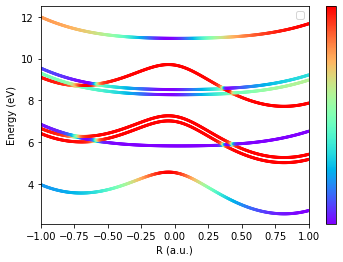

In [52]:
from polaritonic import polaritonic
import numpy as np
#from matplotlib import pyplot as plt
#import matplotlib.animation as animation
import time
import sys
from matplotlib import cm
from matplotlib import rcParams
from matplotlib import pyplot as plt

### initial position
#ri_init = float(sys.argv[1])
ri_init = -0.600006156
### initial velocity
##vi_init = float(sys.argv[2])
vi_init = 3.3375e-5
### photonic mode dissipation rate in meV, gamma
#gamp = float(sys.argv[3]) 
gamp = 0.1
### convert to a.u.
gam_diss_np = gamp * 1e-3 / 27.211

### photonic mode energy in eV
#omp = float(sys.argv[4])
omp = 2.45
### convert to a.u.
omc = omp/27.211
### coupling strength in eV
#gp = float(sys.argv[5])
gp = 0.03
gc = gp/27.211

au_to_ps = 2.4188e-17 * 1e12

### get prefix for data file names
#prefix = sys.argv[6]
prefix = "test"
### filename to write nuclear trajectory to
nuc_traj_fn = "Data/" + prefix + '_nuc_traj.txt'
### filename to wrote PES to
pes_fn = "Data/" + prefix + '_pes.txt'
### filename to write electronic/polaritonic dynamics to
ed_fn = "Data/" + prefix + '_electronic.txt'
### filename to write photonic contributions of each state to
pc_fn = "Data/" + prefix + '_photon_contribution.txt'


### Number of updates!
N_time = 1

### N_thresh controls when you start taking the average position
N_thresh = int( N_time / 4)

r_array = []

options = {
        'Number_of_Photons': 2,
        'Photon_Energys': [omc, 1.1*omc],
        'Coupling_Strengths': [gc, gc], 
        'Photon_Lifetimes': [gam_diss_np, gam_diss_np],
        'Initial_Position': ri_init,
        'Initial_Velocity': vi_init,
        'Mass': 1009883,
        ### temperature in a.u.
        'Temperature': 0.00095,
        ### friction in a.u.
        'Friction': 0.000011,
        ### specify initial state as a human would, not a computer...
        ### i.e. 1 is the ground state... it will be shifted down by -1 so
        ### that it makes sense to the python index convention
        'Initial_Local_State': 3
        
        }

### instantiate
polt = polaritonic(options)
print("gamma",polt.gamma_diss)

polt.Transform_L_to_P()
polt.D_polariton = np.zeros((polt.N_basis_states,polt.N_basis_states),dtype=complex)
polt.D_polariton[polt.initial_state,polt.initial_state] = 1+0j
polt.D_local = np.outer(polt.transformation_vecs_L_to_P[:,polt.initial_state], np.conj(polt.transformation_vecs_L_to_P[:,polt.initial_state])) 

### make this array more manageable
v = polt.transformation_vecs_L_to_P
print(v)


rlist = np.linspace(-1, 1, 500)
PES = np.zeros((len(rlist),polt.N_basis_states))
CES = np.zeros((len(rlist),polt.N_basis_states))

### Get PES of polaritonic system and write to file pes_fn
#pes_file = open(pes_fn, "w")
#pc_file = open(pc_fn, "w")
for r in range(0,len(rlist)):
    wr_str = "\n"
    pc_str = "\n"
    polt.R = rlist[r]
    wr_str = wr_str + str(polt.R) + " "
    pc_str = pc_str + str(polt.R) + " "
    polt.H_e()
    polt.H_total = np.copy(polt.H_electronic + polt.H_photonic + polt.H_interaction)
    polt.Transform_L_to_P()
    v = polt.transformation_vecs_L_to_P
    
    ### get energies and photonic contributions to a given surface
    #print(polt.local_basis)
    for i in range(0,polt.N_basis_states):
        v_i = v[:,i]
        cv_i = np.conj(v_i)
        PES[r,i] = polt.polariton_energies[i]
        pc = 0
        for j in range(0,polt.N_basis_states):
            if polt.gamma_diss[j]>0:
                pc = pc + cv_i[j] * v_i[j]
        CES[r,i] = pc
            
#    pes_file.write(wr_str)
#    pc_file.write(pc_str)

### Close PES file
#pes_file.close()
#pc_file.close()
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('rainbow')
im = ax.scatter(rlist, 27.211*PES[:,0], c=CES[:,0], cmap=cm, s=4) 
im = ax.scatter(rlist, 27.211*PES[:,1], c=CES[:,1], cmap=cm, s=4)
im = ax.scatter(rlist, 27.211*PES[:,2], c=CES[:,2], cmap=cm, s=4) # rlist, 27.211*PPES[:,1], c=LP_p, cmap=cm )
im = ax.scatter(rlist, 27.211*PES[:,3], c=CES[:,3], cmap=cm, s=4)
im = ax.scatter(rlist, 27.211*PES[:,4], c=CES[:,4], cmap=cm, s=4)
im = ax.scatter(rlist, 27.211*PES[:,5], c=CES[:,5], cmap=cm, s=4)
im = ax.scatter(rlist, 27.211*PES[:,6], c=CES[:,6], cmap=cm, s=4)
im = ax.scatter(rlist, 27.211*PES[:,7], c=CES[:,7], cmap=cm, s=4)
cbar = fig.colorbar(im, ticks=[0.1, 0.5, 0.9])
cbar.ax.set_yticklabels(['excitonic', 'polaritonic', 'photonic'])
plt.xlim(-1.,1.)
#plt.ylim(3.5,6.)
plt.xlabel("R (a.u.)")
plt.ylabel("Energy (eV)")
plt.legend()
#plt.savefig(filename)
plt.show()

